<a href="https://colab.research.google.com/github/isaachfp/bi-master/blob/master/ADI/20210126_Amostragem_Aleatoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Função a ser aproximada: Griewank

## **Plot 2D da função Griewank**

![alt text](http://2.bp.blogspot.com/_otsWqKrA2RI/TJHH5DguZjI/AAAAAAAAACo/01VNZLSvrlo/s400/fn_griewank.bmp)

### **Definição e ótimo global:**

![alt text](https://www.cs.unm.edu/~neal.holts/dga/benchmarkFunction/images/griewankLatex.png)

#Declarar a função

In [1]:
import math
def Griewank(input):
    sum = 0
    for x in input:
        sum += x * x
    product = 1
    for i in range(len(input)):
        product *= math.cos(input[i] / math.sqrt(i + 1))
    return 1 + sum / 4000 - product

In [2]:
#Teste de chamada para duas variáveis
Griewank([0,0])

0.0

#Amostragem da função a ser aproximada

In [3]:
import random
# Seed para reprodução de resultados
seed = 10
random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

n = 2
samples = 10_000 # agora eh possivel sepalhar a milhar com _
lower_bound = -512
upper_bound = 512

random_samples = []
for sample in range(samples):
  input = []
  for i in range(n):
    input.append(random.uniform(lower_bound, upper_bound))
  random_samples.append(input)

#converte para numpy array
import numpy as np
random_samples = np.array(random_samples)

random_samples[0:5] # 5 primeiras amostras

array([[  73.11625696,  -72.81760801],
       [  79.96549236, -300.95541029],
       [ 320.84096139,  331.35500547],
       [ 157.15587471, -347.92493412],
       [  21.16542427, -176.3606409 ]])

In [4]:
random_samples.max()

511.929631839443

In [5]:
random_samples.min()

-511.9543578149445

In [6]:
random_samples.shape

(10000, 2)

In [7]:
#Saída para cada input
y = []
for i in random_samples:
  y.append(Griewank(i))

In [8]:
y[0:5]

[3.8837389359143155,
 25.340743877922534,
 54.415994058827444,
 36.87859875084288,
 9.27778843523848]

In [9]:
len(y)

10000

#Separar base em treino e validação

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(random_samples, y, test_size = 0.2, shuffle=True, random_state=seed)

X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

#Treinamento da Rede Neural para aproximar a função

In [12]:
# Importando as bibliotecas do Keras
import keras
from keras.models import Sequential #criar a rede neural
from keras.layers import Dense # cria a rede densamente conectada
from keras.layers import Dropout

In [13]:
# Iniciando a Rede Neural
classifier = Sequential()

# Adicionando a camada de input e a primeira camada escondida
classifier.add(Dense(units = 80, activation = 'tanh', input_dim = n))
classifier.add(Dropout(rate = 0.1))

classifier.add(Dense(units = 50, activation = 'tanh'))
classifier.add(Dropout(rate = 0.1))

# Adicionando a camada de saída
classifier.add(Dense(units = 1, activation = 'linear'))

# Compilando a rede neural
classifier.compile(optimizer = 'adam', loss = 'mse')

# Visualização das camadas da rede
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                240       
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                4050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 4,341
Trainable params: 4,341
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Treinando a rede neural
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint(filepath='best.h5', save_best_only=True) #o arquivo best.h5 salva os pesos que provocam o menor erro da RN
history = classifier.fit(X_train, y_train, batch_size = 64, 
                         epochs = 300, 
                         validation_data = (X_val,y_val), 
                         callbacks=[mc]) #posso incluir aqui as métricas tb. Ex: metrics=[rmse]
# a cada época repasso todos os dados do conjunto de treio, em conjuntos do tamanho do batch_size

Epoch 1/300
125/125 [==============================] - 1s 5ms/step - loss: 2653.8062 - val_loss: 2642.1001
Epoch 2/300
125/125 [==============================] - 0s 2ms/step - loss: 2538.2490 - val_loss: 2313.6921
Epoch 3/300
125/125 [==============================] - 0s 2ms/step - loss: 2169.9966 - val_loss: 1794.0493
Epoch 4/300
125/125 [==============================] - 0s 2ms/step - loss: 1701.8133 - val_loss: 1220.9202
Epoch 5/300
125/125 [==============================] - 0s 3ms/step - loss: 1138.1139 - val_loss: 877.6583
Epoch 6/300
125/125 [==============================] - 0s 2ms/step - loss: 864.4145 - val_loss: 799.8505
Epoch 7/300
125/125 [==============================] - 0s 2ms/step - loss: 777.3900 - val_loss: 781.6188
Epoch 8/300
125/125 [==============================] - 0s 2ms/step - loss: 766.8175 - val_loss: 759.3732
Epoch 9/300
125/125 [==============================] - 0s 2ms/step - loss: 742.7817 - val_loss: 736.6217
Epoch 10/300
125/125 [========================

#Avaliar erros de treino e validação

In [15]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


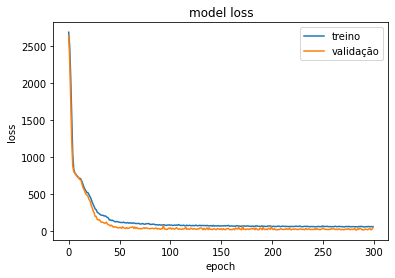

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

#Fazer previsões e avaliar a rede treinada

###Exercício 1: Avalie a rede treinada com 500 dados amostrados com distribuição uniforme. Salve em uma variável chamada 'y_test' os dados gerados.

In [22]:
samples = 500 # agora eh possivel sepalhar a milhar com _

X_test = []
for sample in range(samples):
  input = []
  for i in range(n):
    input.append(random.uniform(lower_bound, upper_bound))
  X_test.append(input)

#converte para numpy array
import numpy as np
X_test = np.array(X_test)

y_test = []
for i in X_test:
    y_test.append(Griewank(i))

In [23]:
X_test.shape

(500, 2)

In [24]:
len(y_test)

500

###Exercício 2: Utilize a rede neural (best.h5) para prever o resultado da função para as entradas geradas acima. Chame a variável com os resultados de 'y_pred'.

In [25]:
classifier.load_weights('best.h5')
y_pred = classifier.predict(X_test)

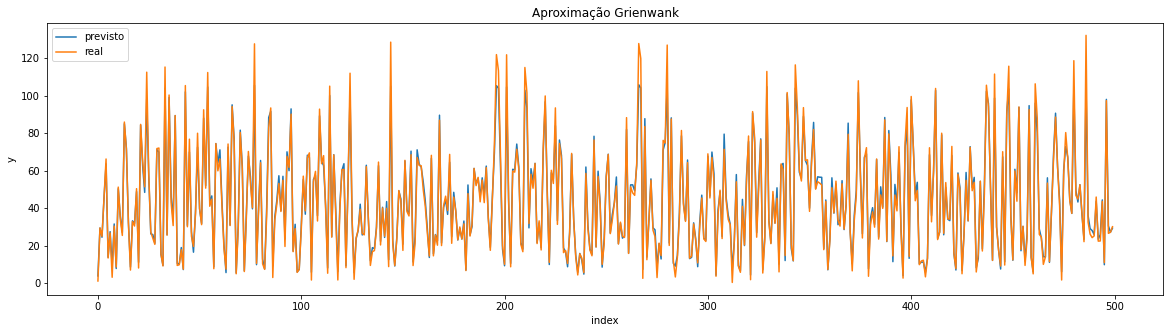

In [26]:
#Real vs. Previsto
plt.figure(figsize=(20,5))
plt.plot(y_pred, label='previsto')
plt.plot(y_test, label='real')
plt.title('Aproximação Grienwank')
plt.ylabel('y')
plt.xlabel('index')
plt.legend()
plt.show()

###Exercício 3: Faça um plot como o acima, mas utilizando somente 50 amostras da base de teste.

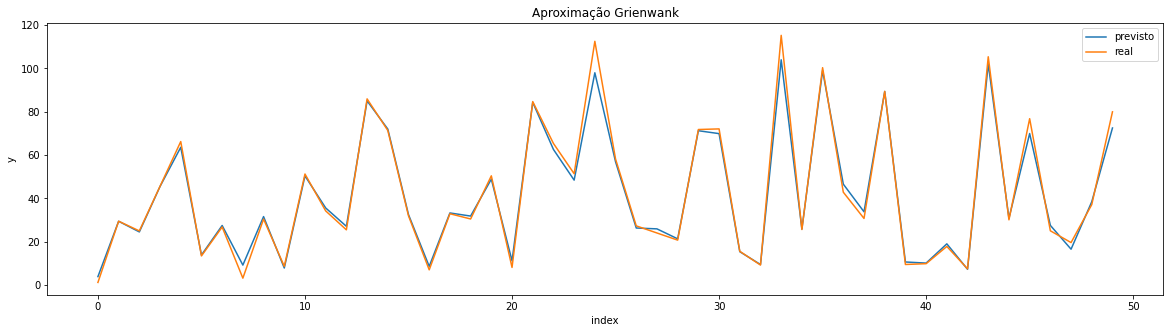

In [27]:
#50 primeiras amostras
#Real vs. Previsto
y_pred_50 = y_pred[0:50]
y_test_50 = y_test[0:50]
plt.figure(figsize=(20,5))
plt.plot(y_pred_50, label='previsto')
plt.plot(y_test_50, label='real')
plt.title('Aproximação Grienwank')
plt.ylabel('y')
plt.xlabel('index')
plt.legend()
plt.show()

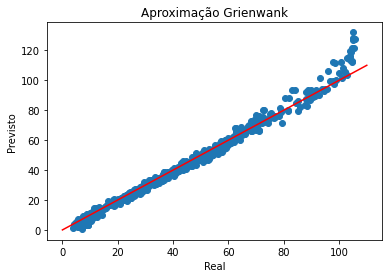

In [28]:
#Real vs. Previsto
plt.scatter(x=y_pred, y=y_test)
plt.title('Aproximação Grienwank')
plt.ylabel('Previsto')
plt.xlabel('Real')

x = [0, 110]
plt.plot(x, x, color='red'); #reta onde y=x
plt.show()

In [29]:
# calcular o erro para a base de teste
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score

mse = mean_squared_error(y_pred, y_test)
print('MSE: ',mse)
r2 = r2_score(y_pred, y_test)
print('R2: ', r2)

MSE:  16.517466303270492
R2:  0.9778716149100958
